# PHÂN TÍCH CẢM XÚC VỚI LSTM (SVA model)

### Giới thiệu bài toán
Trong thực trạng nhiều công ty thương mại điện tử phát triển nở rộ ngày nay, việc thu thập đánh giá từ các bình luận của người dùng là rất cần thiết. Các bình luận này có chứa nhiều thông tin quan trọng, có thể giúp các trang web dễ dàng lọc, đề xuất các mặt hàng, địa điểm phù hợp với từng người dùng và đánh giá chất lượng sản phẩm cũng như dịch vụ của các đối tác.

Với hàng chục nghìn cho tới hàng trăm nghìn bình luận mỗi ngày hiện nay thì việc phân loại các bình luận từ người dùng không phải là điều dễ dàng, và đòi hỏi rất nhiều nhân lực. Cụ thể ở đây, ta quan tâm đến cảm xúc gắn liền với các bình luận, để suy ra thái độ của người dùng và từ đó đánh giá chất lượng các sản phẩm.

Cùng sự phát triển của AI và các phương pháp ML, hiện nay chúng ta có thể giải quyết bài toán này bằng các mô hình Deep Learning với độ chính xác có thể sánh ngang với khả năng đọc hiểu của con người.

Trong bài tập này, ta sẽ tập trung vào phân tích các bình luận tiếng Việt để tìm ra cảm xúc được thể hiện trong bình luận.
![](https://drive.google.com/uc?export=view&id=16m7rYwl40I0CBJKWlu44CyAXEMflcF9R)
![](https://drive.google.com/uc?export=view&id=1MSEwafiJ7hIoRD4QEzL5umCK8FqlAojN)


### Hướng giải quyết bài toán

Ta sẽ dùng mạng **LSTM** (Long Short-Term Memory, dịch thô: Bộ-nhớ Ngắn-hạn Dài) để giải quyết bài toán **Sentiment Analysis**  (dịch thô: Phân-tích Cảm-xúc) trên dữ liệu văn bản.

Đầu vào nhận được là một văn bản.

Đầu ra cần trả về là loại cảm xúc được thể hiện trong văn bản: tích cực, tiêu cực, hay trung lập (positive - negative - neutral). Trong phạm vi của bài tập này, chúng ta chỉ quan tâm đến hai cảm xúc positive và negative.

![caption](https://drive.google.com/uc?export=view&id=1cg-W4IXMKP9jfpCcADKXqXwpgEV19I-f)

### Cách đánh giá mô hình
Mô hình luyện được sẽ được đánh giá trên tập dữ liệu gồm 3000 bình luận (được giấu nhãn) với độ đo F1 score. 

## Tìm hướng giải quyết bài toán

### Tập dữ liệu

Chúng ta sử dụng tập dữ liệu review trên trang Foody với khoảng 30,000 mẫu được gán nhãn, trong đó có 15,000 mẫu positive và 15,000 mẫu negative (Nguồn: https://streetcodevn.com/blog/dataset).

Tập dữ liệu này có thể được tải bằng đoạn code bên dưới:

In [ ]:
# Tải data
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1eF0jg_8P0NnUiiL3HjBaJ8AC2T1sJXiK', dest_path='./assignment4-data.zip', unzip=True)

Trong đó:
- **train.csv**: file csv chứa 27,000 mẫu dữ liệu đã gán nhãn
- **test.csv**: file chứa 3000 mẫu test dùng để đánh giá
- **sample_submission.csv**: file mẫu thể hiện hình thức nộp kết quả
- **word_list.npy**: chứa danh sách các từ tiếng Việt đã xử lý
- **word_vectors.npy**: chứa vectors  biểu diễn các từ trong **word_list.npy**

### Phân tích bài toán dưới góc nhìn Word Vectors


Nếu như chúng ta giữ nguyên định dạng kí tự của văn bản đầu vào thì rất khó để thực hiện các thao tác toán học, như tính tích vô hướng (dot product) , đưa vào hàm softmax, hay các thuật toán trên Neural Net như backpropagation.

Vậy nên, thay vì sử dụng chuỗi kí tự, ta sẽ chuyển  định dạng của văn bản đầu vào thành các vector biểu diễn, để thuận tiện cho việc tính toán.

![Word2Vec](https://drive.google.com/uc?export=view&id=12xKP6pFzDzj-0ToZX-27RjOhRcMFrfeb)

Trong hình minh hoạ ở trên, dữ liệu đầu vào là câu "Tôi ăn ... rồi" với 16 tiếng. Giả sử ta có thể mã hóa mỗi tiếng thành một vector D chiều, ví dụ như:

```
Tôi = [.2 0 .8]
ăn = [0 .6 0]
rồi = [.5 .2 .1]
với D = 3
```

Vậy, cả câu "Tôi ăn ... rồi" có thể được biểu diễn bằng một ma trận 16\*D chiều.

Để ánh xạ từ một **từ** sang một **vector**, chúng ta sử dụng một bộ vector biểu diễn từ đã được luyện sẵn.

### Import các thư viện cần thiết

In [1]:
import os
import sys
import time
import datetime
import math

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf

# Enable Eager Execution
tf.enable_eager_execution()
tf.executing_eagerly() 

import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.__version__

'2.1.0'

## Chuẩn bị dữ liệu huấn luyện

### Tải dữ liệu 
Sau đây ta tiến hành tải dữ liệu từ file `train.csv`

In [3]:
pd.options.display.max_colwidth=1000
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,text,class
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .\nNhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .\nThực_đơn phong_phú đa_dạng , giá siêu rẻ .\nThức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .\nDesert ngọt vừa , không quá ngấy , rất ngon .\nTrà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .\nNói_chung điểm 10 cho chất_lượng , thích quán lắm !",1
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ổn . Tuy_nhiên không_gian tầng 1 hơi hẹp . Ngồi cả ra vỉa_hè . Đồ uống ko ngon lămz,0
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi gần 15p mới mang được ly cà_phê ra . Ông này chỉ khéo quảng_bá chứ với mình chắc không quay lại_nữa .,0
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nên phục_vụ chưa tốt . Đồ uống bình_thường ( đặc_biệt khi so với giá_cả ) và ko có gì đặc_sắc cả .",0
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiếp_đãi , tư_vấn và nói_chuyện rất gần_gũi , rất nhiệt_tình .\nBánh thì rất tuyệt , nhân béo , rau_câu không dùng phẩm . Sau_này có dịp sinh_nhật , mình sẽ order mẫu lớn .\nChúc các bạn làm_ăn phát_đạt !",1


In [4]:
print('Number of train samples in total:', len(train_df))

Number of train samples in total: 27000


In [5]:
print('Number of positives:', np.sum(train_df['class']==1))
print('Number of negatives:', np.sum(train_df['class']==0))

Number of positives: 13518
Number of negatives: 13482


Dữ liệu gồm 3 cột: `id`, `text` và `class`. Trong đó:
- `id`: id của mẫu dữ liệu
- `text`: dữ liệu văn bản, đã được tiền xử lý để gộp từ và dấu câu
- `class`: nhãn của dữ liệu, 1 là positive, 0 là negative

Để giúp hiểu rõ hơn về dữ liệu, ta có thể hiển thị một số review bất kỳ như sau. Các bạn có thể thử nhiều lần để thấy sự đa dạng của các bình luận trong tập dữ liệu (về cách gõ, hành văn, ngôn từ, *vân vân*)

In [6]:
print('Một review tích cực: ')
sample_positive = train_df[train_df['class'] == 1].sample(1)
print(sample_positive.loc[sample_positive.index[0], 'text'])

print('\nMột review tiêu cực: ')
sample_negative = train_df[train_df['class'] == 0].sample(1)
print(sample_negative.loc[sample_negative.index[0], 'text'])


Một review tích cực: 
Mình cùng tụi bạn đến Galaxy xem phim . Nghe_nói quán có mới , lại gần đấy nên cũng kéo vào thử .
Ấn_tượng đầu_tiên của mình " chiếc xe bus " rất xinh_xinh , đáng yêu . Tuy_nhiên không_gian hơi nhỏ , đông người chắc sẽ ồn . Cũng may hôm đấy tụi mình đi ngay lúc quán thưa khách nếu_không đã ra về vì chúng_mình đi vào đã chiếm hẳn 3 bàn .
Vì quán mới mở nên nhiều món chưa có lắm . Chúng_mình kêu cả 3 loại so đa : dâu , chanh , táo . Cũng tạm . Trên vành ly có trang_trí thêm muối , rất lạ .
Khi nào có thời_gian đến xem phim sẽ lại ghé ^ ^

Một review tiêu cực: 
Mình đi ăn_ở đây với bạn với mong_muốn nếm thử ẩm_thực Hàn , cái mình thấy rất hấp dzẫn trên mọi kênh thông_tin . Nhưng_mà ăn rồi mới bị hụt_hẫng . Có_lẽ mình k thích đồ Hàn chứ đồ_ăn ở đây đc mọi ng review khá tốt .
Bạn mình order Cơm trộn Bulgogi , mình ăn cơm trộn cá_ngừ , gọi thêm kimbap cá_hồi , bánh gạo tokbokki .
Cơm trộn bulgogi nóng từ trog nóng ra , quán có máy_lạnh mà cơm gọi ra cả tiếng vẫn nóng nó

Tiếp theo ta load dữ liệu từ file `test.csv`.

In [7]:
test_df = pd.read_csv('../input/test.csv')
test_df.head()

,id,text
0,2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon"
1,e3f0ea32,"Ăn ở đây từ trc khi chủ nhà xây nhà mới . chất lg ko đổi còn giá có tăng từ từ 1-2k : ) )\nphần mìh kiu là 2 thường 2 trứng 22k - hơi no tẹo và CỰC KÌ NGONNN > <\nđi vạn kiếp rẽ vào hẻm có biển hoa đàm ni tự và đi chừng 50m là tới , vì hẻm 2m nên để xe bên ngoài dọc theo 2 dãy nhà , chú chủ sẽ sắp xếp xe lại nhưng mình khuyến khích các b mua về : ) ) ăn tại chỗ thì bàn ghế sạch sẽ , ly uống nước là loại dùng 1 lần - > kết điểm này ! ! !\nphục vụ của 2 vk ck chủ thì miễn bàn , cực kì thân thiện . dạo này có 1 cô nữa phụ bán nhưng ko dc lanh lẹ lắm .\n* quán chỉ bán buổi sáng tới chừng 9-10g là hết . lâu lâu thì 11g .\n* hành phi tự làm ngon và giòn lắm nhé ^ ^ còn bánh cuốn thì gọi tới đâu làm tới đó , ko qá lâu và bánh còn ấm ."
2,8743eae3,"Các bạn đến ăn ngay và luôn đi nhé ! !\nMình từ trước giờ chỉ Súp cua Súp óc heo làm tới , từ khi tới quán , mình đã biết thêm nhiều loại khác ( rong biển , hến , thập cẩm , . . mới đây còn có thêm súp còi điệp ) . Không chỉ có súp không âu nha , nhìn menu mà món nào cũng muôn ăn ... Ah , bánh Flan trà xanh cực ngon luôn , món khoái khẩu của mình ấy ... Mình không có thói quen chộp hình thức ăn trước khi ăn , nên các bạn đến ngay SÚP SÀI GÒN Q4 và cảm nhận nhé ^ ^"
3,7b554248,"Đây gần như quán ruột của mình luôn : ) ) đây đồ ăn ngon , nhân viên dễ thương , mấy anh giữ xe phía ngoài cũng dễ thương ko kém : ) ) giá cả thì hợp lý khỏi bàn luôn rồi . Đây là 3 món ruột , lần nào đến cũng phải ăn : ) ) ) hahaaa"
4,bedd1403,"Tiếc là 25 năm sống ở Tây Ninh thì đây là lần đầu tiên mình ghé .\nThức ăn rất Việt Nam , ngon và vị tuyệt vời , giá hợp lý .\nKhuyết điểm :\nGiờ cơm trưa quán đắc nên đợi rất lâu ,\nMình quên giử số điện thoại để đặt chổ và thức ăn trước , a e ai ghé thì thêm vào giúp .\nHơi nóng , và chắc vì quán đông quá nên phần mỷ quan có điễm trừ ,"


In [8]:
print('Number of test samples in total:', len(train_df))

Number of test samples in total: 27000


### Tải bộ word embeddings (vector biểu diễn từ, dịch thô là "từ nhúng (vào không gian vector)")
Đầu tiên, để có thể biểu diễn một từ bằng một vector, ta sẽ sử dụng mô hình đã được luyện sẵn (pretrained model). Ở đây ta sẽ dùng mô hình tiếng Việt trong fasttext, bộ biểu diễn từ cho 157 ngôn ngữ do Facebook AI Research Lab thực hiện (nguồn: https://fasttext.cc).

Tuy nhiên, kích thước của mô hình luyện sẵn khá lớn (khoảng 1,2 GB). Mô hình luyện sẵn bao gồm khoảng 2 triệu từ, mỗi từ lại được biểu diễn dưới dạng một vector 300 chiều.

Kích thước lớn của mô hình gây khó khăn cho việc tải và sử dụng nó cho bài toán của chúng ta. Vì vậy, đội giảng dạy đã thu gọn mô hình trên, với số lượng từ vừa đủ để có thể xử lý tập dữ liệu review đồ ăn của Foody.

In [9]:
words_list = np.load('../input/words_list.npy')
print('Prunned vocabulary loaded!')
words_list = words_list.tolist()
word_vectors = np.load('../input/word_vectors.npy')
word_vectors = np.float32(word_vectors)
print ('Word embedding matrix loaded!')

Prunned vocabulary loaded!
Word embedding matrix loaded!


Để đảm bảo dữ liệu được tải một cách chính xác, ta nên kiểm tra xem số từ vựng và số chiều của ma trận biểu diễn từ (word embedding) có khớp với nhau hay không? Trong trường hợp này số từ được giữ lại là 19899 và số chiều của mỗi vector biểu diễn là 300 chiều.

In [10]:
print('Size of the vocabulary: ', len(words_list))
print('Size of the word embedding matrix: ', word_vectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


### Cách lấy word vector của một từ

`words_list` và `word_vectors` đã được thiết lập sẵn sao cho vector đầu tiên trong `word_vectors` sẽ tương ứng với từ đầu tiên `words_list`. Tương tự với cặp vector và từ thứ hai, thứ ba, vân vân, đến cuối.


In [11]:
np.set_printoptions(threshold=5)
for i in range(5):
  print('Index', i, 'thuộc về từ', words_list[i])
  print('có biểu diễn vector là', word_vectors[i], '\tkích thước', word_vectors[i].shape)
  print()

Index 0 thuộc về từ ăm
có biểu diễn vector là [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228] 	kích thước (300,)

Index 1 thuộc về từ sửng_sốt
có biểu diễn vector là [-0.0535  0.0028  0.0876 ... -0.0419  0.0083 -0.0112] 	kích thước (300,)

Index 2 thuộc về từ có_học
có biểu diễn vector là [-0.0165 -0.0346  0.0616 ... -0.0876  0.0095 -0.0098] 	kích thước (300,)

Index 3 thuộc về từ việc_làm
có biểu diễn vector là [ 0.0024  0.0056  0.1076 ... -0.0454 -0.0175 -0.0269] 	kích thước (300,)

Index 4 thuộc về từ vanila
có biểu diễn vector là [ 0.0722 -0.0154  0.0271 ... -0.0013  0.033   0.054 ] 	kích thước (300,)



Theo như trên, để truy xuất vector một từ nhất định thì ta cần biết chỉ số của từ đó. Lấy ví dụ trường hợp ta muốn biết biểu diễn vector của từ "ngon" thì ta cần thực hiện các bước sau:


In [12]:
# Bước 1
word = 'ngon'
  
# Bước 2
word_idx = words_list.index(word)

# Bước 3
word_vec = word_vectors[word_idx]

Tuy nhiên, phương pháp trên khá chậm, và sẽ trở nên rất chậm khi ta cần truy xuất hàng trăm, hàng nghìn vector của các từ trong câu. Khúc mắc nằm ở bước 2: việc tìm index của một từ trong một list (không có phần tử trùng) có độ phức tạp O(n). Ta có thể làm nhanh hơn thế.

In [13]:
word2idx = {w:i for i,w in enumerate(words_list)}
print(word2idx)

{'ăm': 0, 'sửng_sốt': 1, 'có_học': 2, 'việc_làm': 3, 'vanila': 4, '260000': 5, 'linh_chi': 6, 'chảy_máu': 7, 'cũ_kĩ': 8, 'chính_thức': 9, 'đi_đứng': 10, 'bố_trí': 11, 'mì_chính': 12, 'ái_ngại': 13, 'socôla': 14, 'deep': 15, '218': 16, 'khẳng_khái': 17, 'mưa_gió': 18, 'ụt_ụt': 19, 'lưc': 20, 'online': 21, 'dều': 22, 'mist': 23, 'dẽo': 24, 'mifnh': 25, 'nhảy': 26, 'đại': 27, 'hoa_sen': 28, 'wouldn': 29, 'hạn_hẹp': 30, 'ay': 31, 'chòn': 32, 'núi_rừng': 33, 'signature': 34, 'tuơng': 35, 'phạt': 36, 'tâp': 37, 'đại_hội': 38, 'địa_điểm': 39, 'bao_tử': 40, '6g': 41, 'chêt': 42, 'chi_tiết': 43, 'vung_vãi': 44, 'thố': 45, 'trê': 46, 'tẻ_nhạt': 47, 'trinh_thám': 48, 'thành_thật': 49, 'khèo': 50, 'lai_tạp': 51, 'nguyệt': 52, 'thời_kỳ': 53, 'giử': 54, 'tám': 55, 'thét': 56, 'đuòng': 57, 'chung_quanh': 58, 'thươ': 59, 'tiếng_tăm': 60, 'đánh_bạn': 61, '11h15': 62, 'spaghetty': 63, 'opening': 64, '2013': 65, 'tấn_công': 66, 'ăn_bẩn': 67, 'pate': 68, 'mem': 69, '4share': 70, 'loạn_xạ': 71, 'tug': 72, 

In [14]:
# Bước 1
word = 'ngon'

# Bước 2
word_idx = word2idx[word]

# Bước 3
word_vec = word_vectors[word_idx]

Thông qua dictionary `word2idx`, việc truy xuất chỉ số của một từ bất kì đã giảm độ phức tạp xuống còn O(1). Việc này sẽ giúp tăng tốc quá trình biến đổi tập dữ liệu của chúng ta ở dưới.


### Tiền xử lý văn bản

Để tiết kiệm thời gian, tập dữ liệu được cung cấp đã được **tách từ** sẵn. Những từ ghép gồm nhiều tiếng sẽ có dấu '_' nối giữa các tiếng, ví dụ: 'sinh_viên', 'máy_chiếu_hình'.

> *Tách từ tiếng Việt* là một bài toán không đơn giản, và cũng **nằm ngoài phạm vi của khóa học này**. Trong tiếng Anh, hầu hết các từ đều được tách bằng dấu cách. Tuy nhiên, trong tiếng Việt, dấu cách được dùng để tách biệt các **tiếng** chứ không phải các **từ**, nên đây là một vấn đề quan trọng cần lưu ý khi xử lý văn bản tiếng Việt.



Ngoài ra, bạn cũng được cung cấp sẵn các hàm nhằm loại bỏ các ký tự đặc biệt trong văn bản. Tham khảo hàm `clean_sentences` ở dưới.

In [15]:
# Loại bỏ các dấu câu, dấu ngoặc, chấm than chấm hỏi, vân vân..., chỉ chừa lại các kí tự chữ và số
import re
# re = regular expressions
strip_special_chars = re.compile("[^\w0-9 ]+")

def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

### TODO 1: Viết hàm biểu diễn văn bản thành ma trận biểu diễn từ

Tiến thêm một bước từ việc biểu diễn một từ bằng một vector, ở phần này ta sẽ biểu diễn **một câu có nhiều từ** dưới dạng **một ma trận có nhiều vector**.

Ví dụ: _"Món này ăn hoài không biết chán"_

Đầu tiên, với mỗi từ trong câu trên, ta tìm chỉ số (index) tương ứng của từ trong `words_list`, rồi lưu tất cả các chỉ số đó vào một vector đặt tên là `sentence_indices`.

Sau đó, chúng ta có thể sử dụng hàm tra cứu ma trận word embedding của thư viện Tensorflow `tf.nn.embedding_lookup` để tra các vector tại các chỉ số trong `sentence_indices`. 

Nếu ta đặt giới hạn độ dài tối đa của mỗi câu là 10 từ, thì **ma trận biểu diễn câu** sẽ có kích thước *10 x 300*, tương ứng với *10 từ*, mỗi từ là 1 vector *300 phần tử*. Dĩ nhiên, nếu trong tập dữ liệu có nhưng câu dài hơn 10 từ thì ta có thể nâng giới hạn này lên cho phù hợp.

![Embedding](https://drive.google.com/uc?export=view&id=1UvvIa22H3RpWCs_kkzYPprjAPY2-9Ov5)

**Lưu ý**: Trường hợp gặp từ nào không có trong `words_list`, là bộ "từ điển" chứa những từ mà ta "biết" (tức là có biểu diễn vector), thì ta sẽ gán cho từ đó chỉ số của từ `UNK` (unknown).


In [16]:
def get_sentence_indices(sentence, max_seq_length, _words_list):
    """
    Hàm này dùng để lấy index cho từng từ
    trong câu (không có dấu câu, có thể in hoa)
    Parameters
    ----------
    sentence là câu cần xử lý
    max_seq_length là giới hạn số từ tối đa trong câu
    _words_list là bản sao local của words_list, được truyền vào hàm
    """
    indices = np.zeros((max_seq_length), dtype='int32')
    
    # Tách câu thành từng tiếng
    words = [word.lower() for word in sentence.split()]
    
    # Lấy chỉ số của UNK
    unk_idx = word2idx['UNK']
    
    ### TODO 1 ###
    # Viết lệnh cần thực hiện trong vòng lặp dưới [tgay vào pass]
    # Vòng lặp chạy qua tất cả các phần tử trong list `words`, tức các từ trong câu
    # vd: iter 1: idx = 1, word = tôi
    #     iter 2: idx = 2, word = đi
    #     iter 3: idx = 3, word = học
    #     iter 4: v.v
    # Trong mỗi vòng lặp, hãy thay các phần tử tương ứng
    # của `indices` bằng các chỉ số/index của các từ trong câu
    # LƯU Ý 1: len(indices) có thể ngắn hơn len(words)
    # LƯU Ý 2: câu có thể chứa những từ out of vocabulary (OOV), tức không có trong _word_list
    ### START CODE HERE ###
    for idx, word in enumerate(words):
        if idx < max_seq_length:
          if( word in _words_list):
            word_idx = word2idx[word]
          else:
            word_idx = word2idx['UNK']       
        
          indices[idx] = word_idx 
        else:
          break
          
    ### END CODE HERE ###
    return indices

Ở ví dụ dưới đây, ta kiểm tra lại hàm vừa cài đặt ở TODO 1. Nếu bạn thực hiện đúng thì vector `sentence_indices` sẽ có giá trị là: `[119, 8136, 4884, 18791, 16614, 15951, 3371, 0, 0, 0]`

In [17]:
# Ví dụ:
sentence = "Món này ăn hoài không biết chán"

# Tiền xử lý câu
sentence = clean_sentences(sentence)

# Lấy index của từng từ
sentence_indices = get_sentence_indices(sentence, max_seq_length=10, _words_list=words_list)

# Hiển thị các chỉ số tương ứng với các từ trong câu
for i in range(len(sentence.split())):
  print(sentence.split()[i],'--->',sentence_indices[i])

# Hiển thị đầy đủ sentence_indices
print(sentence_indices)
print('Chú ý: các chỉ số thứ 7, 8, 9 của sentence_indices bằng 0')

món ---> 119
này ---> 8136
ăn ---> 4884
hoài ---> 18791
không ---> 16614
biết ---> 15951
chán ---> 3371
[ 119 8136 4884 ...    0    0    0]
Chú ý: các chỉ số thứ 7, 8, 9 của sentence_indices bằng 0


In [18]:
# Ma trận biểu diễn:
print('Vector representation of sentence:')
print(tf.nn.embedding_lookup(word_vectors,sentence_indices))

Vector representation of sentence:
tf.Tensor(
[[-0.1823 -0.0638  0.2376 ...  0.1462 -0.1092  0.0137]
 [ 0.027  -0.0542  0.1437 ... -0.0913  0.0114  0.0132]
 [ 0.021   0.0102  0.0096 ...  0.411  -0.2519  0.0151]
 ...
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]], shape=(10, 300), dtype=float32)


### Khảo sát tập dữ liệu huấn luyện

Với khối lượng dữ liệu lớn (27,000 mẫu), nếu chúng ta chọn đặt **giới hạn số từ tối đa cho một câu** (`MAX_SEQ_LENGTH`) quá cao thì sẽ phí bộ nhớ khi biểu diễn những câu review quá ngắn. Ngược lại, nếu đặt giới hạn quá thấp thì ở những câu dài, ta sẽ bị mất các từ cuối, có khả năng ảnh hưởng đến việc suy đoán cảm xúc.

Vì vậy, ta cần thống kê độ dài của các mẫu dữ liệu huấn luyện.


In [19]:
num_words = [len(clean_sentences(x).split()) for x in list(train_df['text'])]
print('The total number of samples is', len(train_df))
print('The total number of words in the files is', sum(num_words))
print('The average number of words in the files is', sum(num_words)/len(num_words))

The total number of samples is 27000
The total number of words in the files is 2252760
The average number of words in the files is 83.43555555555555


Chúng ta có thể sử dụng thư viện Matplotlib để minh họa phân bố về chiều dài của các câu review trong tập dữ liệu:

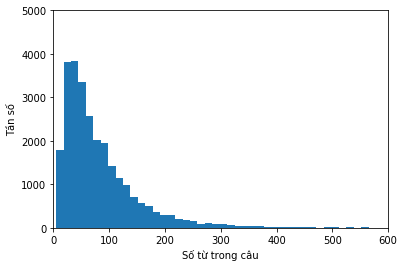

In [20]:
import matplotlib.pyplot as plt
plt.hist(num_words, 100)
plt.xlabel('Số từ trong câu')
plt.ylabel('Tần số')
plt.axis([0, 600, 0, 5000])
plt.show()

Dựa trên biểu đồ histogram ở trên chúng ta có thể thấy chọn đặt giới hạn `MAX_SEQ_LENGTH` 200 là tương đối hợp lý. 

In [21]:
MAX_SEQ_LENGTH = 200

### Chuyển dữ liệu văn bản thành ma trận

Trong phần này, chúng ta sẽ tiến hành biến đổi text của review thành vector index của các từ trong `words_list`. Tập hợp các vector của `train_df` sẽ tạo thành ma trận `train_ids`

In [22]:
def text2ids(df, max_length, _word_list):
    """
    Biến đổi các text trong dataframe thành ma trận index
    
    Parameters
    ----------
    df: DataFrame
        dataframe chứa các text cần biến đổi
    max_length: int
        độ dài tối đa của một text
    _word_list: numpy.array
        array chứa các từ trong word vectors
    
    Returns
    -------
    numpy.array
        len(df) x max_length contains indices of text
    """
    ids = np.zeros((len(df), max_length), dtype='int32')
    for idx, text in enumerate(tqdm(df['text'])):
        ids[idx,:] = get_sentence_indices(clean_sentences(text), max_length, _word_list)
    return ids

In [23]:
# LƯU Ý: Bước thực hiện này tương đối mất thời gian.
# Nếu đã có file train_ids.npy rồi thì ra có thể load lên
# và sử dụng luôn ở bước tiếp theo

print("Converting train_df...")
train_ids = text2ids(train_df, MAX_SEQ_LENGTH, words_list)
np.save('train_ids.npy', train_ids)


  0%|          | 9/27000 [00:00<05:30, 81.58it/s]

Converting train_df...


100%|██████████| 27000/27000 [05:48<00:00, 77.42it/s]


In [24]:
# Trường hợp đã tính toán và lưu ma trận rồi thì ta có thể load lên
train_ids = np.load('train_ids.npy')

In thử word indices của review đầu tiên:

In [25]:
print('Word indices of the first review: ')
print(train_ids[0])


Word indices of the first review: 
[10774 11975  4826 ...     0     0     0]


### Chia dữ liệu thành train, validation và test

Chia dữ liệu `train_ids` và cột `class` của `train_df` thành 3 phần **train : validation : test = 0.8 : 0.1 : 0.1**

In [26]:
train_x, test_validation_x, train_y, test_validation_y  = train_test_split(train_ids, train_df['class'], test_size=0.2, random_state=2019)
validation_x, test_x, validation_y, test_y = train_test_split(test_validation_x, test_validation_y, test_size=0.5, random_state=2018)

### TODO 2: Khởi tạo các `train_dataset`, `validation_dataset`, `test_dataset`

In [27]:
BATCH_SIZE = 256 # Có thể chạy trên Tesla K80 12GB VRAM

In [28]:
### TODO 2
# Sử dụng các biến đã tạo ở trên, hình thành 3 tập dataset
# train_dataset, validation_dataset, test_dataset
#
# GỢI Ý:
# Cả 3 tập đều có quy trình tạo như nhau, chỉ khác về tham biến.
#
# Một dataset được tạo như sau:
# dataset = tf.data.Dataset.from_tensor_slices((features,targets))
#
# Các dataset sau đó cần được chia thành batch.
# dataset = dataset.batch(batch_size)
#
# Tham khảo: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
### START CODE HERE
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)) # train_x, train_y
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y)) # validation_x, validation_y
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)) # test_x, test_y

train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
### END CODE HERE

Chạy dòng lệnh sau để kiểm tra TODO 2:

In [29]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('FIRST BATCH:')
        print('X =',x)
        print('y =',y)
print("Total: ", idx)

FIRST BATCH:
X = tf.Tensor(
[[12844  5596  4884 ...     0     0     0]
 [10774 16521 13952 ...     0     0     0]
 [ 7446 10698 10774 ...     0     0     0]
 ...
 [ 4884 16995  4601 ...     0     0     0]
 [ 3913 15085 14017 ...     0     0     0]
 [ 4788 14598   310 ...     0     0     0]], shape=(256, 200), dtype=int32)
y = tf.Tensor([0 0 1 ... 0 1 1], shape=(256,), dtype=int32)
Total:  84


Nếu cài đặt đúng, kết quả sẽ có dạng như sau:
```
FIRST BATCH:
X = tf.Tensor(
[[12844  5596  4884 ...     0     0     0]
 [10774 16521 13952 ...     0     0     0]
 [ 7446 10698 10774 ...     0     0     0]
 ...
 [ 4884 16995  4601 ...     0     0     0]
 [ 3913 15085 14017 ...     0     0     0]
 [ 4788 14598   310 ...     0     0     0]], shape=(256, 200), dtype=int32)
y = tf.Tensor(
[0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0
 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1], shape=(256,), dtype=int32)
Total:  84
```

> *Câu hỏi phụ: số 84 trong kết quả trên nghĩa là gì? Liên hệ trở lại với BATCH_SIZE.*



### Tổng kết quá trình chuẩn bị dữ liệu huấn luyện

Quá trình kết hợp ma trận chỉ số (indices) và ma trận biểu diễn từ (word embeddings) sang data tensor dùng để huấn luyện được mô tả như hình dưới đây:
![caption](https://drive.google.com/uc?export=view&id=1SST9hIt4jboWYr4A41-wI2jMbKI25A9e)

Từ ma trận indices và ma trận embedding, sử dụng `tf.nn.embedding_lookup` ta thu được ma trận có kích thước `(BATCH_SIZE, MAX_SEQUENCE_LENGTH, WORD_VEC_DIM)`.


In [30]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('EMBEDDING OF FIRST BATCH:')
        print(tf.nn.embedding_lookup(word_vectors, x))

EMBEDDING OF FIRST BATCH:
tf.Tensor(
[[[ 2.920e-02 -2.410e-02  7.960e-02 ...  8.000e-04 -2.180e-02 -7.700e-03]
  [-7.600e-03 -4.540e-02  4.880e-02 ... -1.456e-01 -1.232e-01 -2.590e-02]
  [ 2.100e-02  1.020e-02  9.600e-03 ...  4.110e-01 -2.519e-01  1.510e-02]
  ...
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]]

 [[-5.800e-03 -6.460e-02  1.976e-01 ... -1.739e-01  1.770e-02 -2.780e-02]
  [-6.140e-02  4.890e-02  8.530e-02 ... -3.620e-02  4.590e-02 -6.180e-02]
  [ 2.150e-02 -4.110e-02  2.015e-01 ... -9.910e-02 -4.840e-02  6.100e-03]
  ...
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]]

 [[ 4.510e-02 -2.430e-02  2.318e-01 ...  7.880e-02 -5.000e-

Chú ý vào phần shape của tensor output ở trên, ta có thể thấy kích thước của từng batch dữ liệu, tương ứng với hình minh họa trên.

Vậy là ta đã hoàn thành quá trình chuẩn bị dữ liệu!

Tiếp theo, ta sẽ xây dựng mô hình RNN để huấn luyện trên dữ liệu này.

## Xây dựng mô hình RNN

Trong bài tập này, ta sẽ sử dụng mạng Long Short-Term Memory (LSTM) - Bộ nhớ Ngắn hạn Dài, một dạng kiến trúc RNN để gỉải quyết bài toán phân tích cảm xúc.

**Kiến trúc mạng LSTM** ta sẽ sử dụng trong bài tập này được mô tả như hình dưới. Để tăng độ phức tạp của mô hình, ta chồng nhiều tầng LSTM lên nhau (**Stacked LSTM layers**). Giữa tầng LSTM dưới và tầng LSTM trên, ta đặt một lớp dropout.

Việc chồng thêm các tầng LSTM sẽ giúp cho mô hình có khả năng "suy luận" ở những mức độ trừu tượng/abstraction cao hơn (tương tự như khi dùng nhiều tầng CNN), nhưng đồng thời cũng làm tăng số lượng tham số, đồng nghĩa với việc làm tăng đô phức tạp của mô hình và thời gian huấn luyện.

![caption](https://drive.google.com/uc?export=view&id=10m5sPPmba__bHx6V9Wp3fp1Wot5uOhBG)

### Chọn  LSTM layer

Để hỗ trợ tốt nhất cho việc tính toán trên GPU, keras hỗ trợ hai loại LSTM layer: 1 loại dành được tối ưu cho các tính toán trên GPU, và một loại dành cho CPU.

In [31]:
# if tf.test.is_gpu_available():
#     print('Using GPU LSTM')
#     lstm_layer = tf.keras.layers.CuDNNLSTM
# else:
#     print('Using CPU LSTM')
#     import functools
#     lstm_layer = functools.partial(
#             tf.keras.layers.LSTM, recurrent_activation='sigmoid')

### TODO 3: Định nghĩa và tạo mô hình
Ở bước này, chúng ta cần định nghĩa mô hình `SentimentAnalysisModel`, kế thừa từ `tf.keras.Model`. Chúng ta sẽ áp dụng mô hình stacked LSTM ở trên để xây dựng `SentimentAnalysisModel`.

Các bạn theo dõi hướng dẫn cụ thể trong code ở dưới.

Hoàn thành hàm `__init__` để tạo định nghĩa của `class SentimentAnalysisModel`.

Hoàn thành hàm `call` để tạo lệnh feedforward khi gọi một `object` của `class SentimentAnalysisModel`.

In [32]:
class SentimentAnalysisModel(tf.keras.Model):
    """
    Mô hình phân tích cảm xúc của câu
    
    Properties
    ----------
    word2vec: numpy.array
        word vectors 
    lstm_layers: list
        list of lstm layers, lstm cuối cùng sẽ chỉ trả về output của lstm cuối cùng
    dropout_layers: list
        list of dropout layers
    dense_layer: Keras Dense Layer
        lớp dense layer cuối cùng nhận input từ lstm, 
        đưa ra output bằng số lượng class thông qua hàm softmax
    """
    def __init__(self, word2vec, lstm_units, n_layers, num_classes, dropout_rate=0.25):
        """
        Khởi tạo mô hình
        
        Paramters
        ---------
        word2vec: numpy.array
            word vectors 
        lstm_units: int
            số đơn vị lstm
        n_layers: int
            số layer lstm xếp chồng lên nhau
        num_classes: int
            số class đầu ra
        dropout_rate: float
            tỉ lệ dropout giữa các lớp
        """
        super().__init__(name='sentiment_analysis')
        
        # Khởi tạo các đặc tính của model
        self.word2vec = word2vec
        
        self.lstm_layers = []  # List chứa các tầng LSTM
        self.dropout_layers = []  # List chứa các tầng dropout

        ### TODO 3.1
        # Vòng lặp dưới chạy qua N tầng trong stack
        # mỗi tầng sẽ có 1 lstm_layer và 1 dropout_layer
        # 
        # Khởi tạo lstm_layer (GPU) với các tham biến sau:
        # lstm_layer(units=..., return_sequences=[True/False])
        # Tham khảo: https://keras.io/layers/recurrent/#cudnnlstm
        #
        # Khởi tạo lstm_layer (CPU) với các tham biến sau:
        # lstm_layer(units=..., return_sequences=[True/False])
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
        # 
        # LƯU Ý:
        # return_sequence của lstm_layer nhận giá trị True ở mọi tầng  
        # trong stack, ngoại trừ tầng cuối cùngg
        #
        # Khởi tạo dropout_layer với các tham biến sau:
        # new_dropout = tf.keras.layers.Dropout(rate=...)
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
        # 
        # Sau khi khởi tạo lstm_layer và dropout_layer
        # hãy thêm chúng vào 2 list tương ứng
        # self.lstm_layers và self.dropout_layers
        #
        # Cuối cùng, khởi tạo tầng fully-connected/dense
        # tf.keras.layers.Dense(num_classes=..., activation=' ')
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
        #
        ### START CODE HERE
        
        for i in range(n_layers):
            new_lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)
            self.lstm_layers.append(new_lstm)
            new_dropout = tf.keras.layers.Dropout(rate=dropout_rate)
            self.dropout_layers.append(new_dropout)
          
        #Tầng cuối cùng  
        new_lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=False)
        self.lstm_layers.append(new_lstm)
        
        self.dense_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
        ### END CODE HERE
        
    def call(self, inputs):
        ### TODO 3.2
        # Thực hiện các bước biến đổi khi truyền thuận input qua mạng
        # Điền code vào các đoạn pass
        ### START CODE HERE
        inputs = tf.cast(inputs, tf.int32)
        # Input hiện là indices, cần chuyển sang dạng vector
        # sử dụng:
        # tf.nn.embeddings_lookup(embeddings, indices)
        
        x = tf.nn.embedding_lookup(self.word2vec, inputs)
      
        # Truyền thuận inputs lần lượt qua các tầng
        # ở mỗi tầng, truyền input qua các layer: lstm > dropout
        # vd: x = first_lstm(x)
        #     x = first_dropout(x)
        #     x = second_lstm(x)
        #     v.v.
        n_layers = len(self.dropout_layers)
        
        for i in range(n_layers):
          x = self.lstm_layers[i](x)
          x = self.dropout_layers[i](x)
          
        x = self.lstm_layers[-1](x)
          
        x = self.dense_layer(x)
             
        # Gán giá trị tầng cuối cùng vào out và trả về
        out = x
        
        return out
        ### END CODE HERE
        

Tiếp theo, ta lựa chọn các hyperparameters (siêu tham số) phù hợp, rồi tạo mô hình dựa trên định nghĩa.

In [33]:
# Các hyperparameters
LSTM_UNITS = 128
N_LAYERS = 2
NUM_CLASSES = 2

In [34]:
model = SentimentAnalysisModel(word_vectors, LSTM_UNITS, N_LAYERS, NUM_CLASSES)

### Huấn luyện mô hình

Đầu tiên, chọn các tham số huấn luyện:

In [35]:
LEARNING_RATE = 0.001
EPOCHS = 100

Ta sẽ sử dụng thuật toán tối ưu hoá Adam với learning rate là `LEARNING_RATE`:

> Tham khảo thêm về Adam ở các link dưới:
>  * tiếng Anh: https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#adam
>  * tiếng Anh: http://ruder.io/optimizing-gradient-descent/index.html#adam
>  * tiếng Việt: https://viblo.asia/p/thuat-toan-toi-uu-adam-aWj53k8Q56m



In [36]:
import tensorflow.compat.v1 as tf
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

Các biến khác hỗ trợ cho việc huấn luyện:

In [37]:
global_step = tf.train.get_or_create_global_step()
# Thư mục chứa checkpoint
checkpoint_dir = './model'
# Mẫu tên checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{score}")

#### TODO 4: Viết hàm huấn luyện từng epoch

Trước tiên, ta sẽ import vài thành phần từ thư viện `fastprogress` để tiện cho việc biểu diễn 
quy trình huấn luyện:

In [38]:
from fastprogress import master_bar, progress_bar

Ta cần xây dựng hàm `epoch_training`, thực hiện các bước **truyền thuận**, **truyền ngược** và **tối ưu** tại mỗi epoch.

Hàm `epoch_training`:
* nhận các tham biến `model`, `dataset`, `global_step`, `mb`, và `num_step`
* trả về giá trị loss trung bình của model

In [39]:
def epoch_training(model, dataset, global_step, mb, num_step):
    """
    Huấn luyện mô hình qua 1 epoch
    
    Parameters
    ----------
    model: tf.keras.Model
        model cần huấn luyện
    dataset: tf.Dataset
        dataset dùng để huấn luyện
    global_step: global step 
    mb: fastprogress.master_bar
        thanh biểu diễn tiến độ
    num_step: int
        số bước lặp trong mỗi epoch
    Returns
    -------
    float
        Giá trị loss trung bình của epoch
    """
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)
        
        with tf.GradientTape() as tape:
            ### TODO 4.1
            # Truyền thuận - Feedforward
            # Để tạo giá trị predictions
            ### START CODE HERE
            predictions = model(inp)
            ### END CODE HERE
            
            ### TODO 4.2
            # Sử dụng tf.losses.sparse_softmax_cross_entropy để tính loss
            # Tham khảo: https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/losses/sparse_softmax_cross_entropy
            ### START CODE HERE
            loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=predictions)
            ### END CODE HERE
          
            # Thêm loss của batch vào train_losses
            train_losses.append(loss)
            
        
        
        ### TODO 4.3
        #  Truyền ngược - Backprop: tính gradient của loss
        # theo các tham số mô hình (model.trainable_variables)
        # sử dụng tape.gradient
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
        ### START CODE HERE
        grads = tape.gradient(train_losses, model.trainable_variables)
        ### END CODE HERE
        
        ### TODO 4.4
        # Dùng gradient để tối ưu các tham số
        # sử dụng optimizer.apply_gradients
        # vd: optimizer.apply_gradients(zip(dloss_over_dvars, vars), global_step = global_step)
        # LƯU Ý: Không cần gán giá trị của optimizer.apply_gradients cho biến
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
        ### START CODE HERE
        optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step=global_step)
        ### END CODE HERE
        
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
        
    # Trả về loss trung bình
    return sum(train_losses)/ len(train_losses)

#### TODO 5: Viết hàm đánh giá từng epoch

Ta cần xây dựng hàm `epoch_evaluation`, thực hiện duy nhất bước **truyền thuận** để tính loss.

Hàm `epoch_evaluation`:
* nhận vào `model`, `dataset`, `mb`, và `num_step`
* trả về giá trị `loss`, `f1_score` của model trên tập `dataset` 

In [40]:
def epoch_evaluation(model, dataset, mb, num_step):
    """
    Đánh giá mô hình qua 1 epoch
    
    Parameters
    ----------
    model: tf.keras.Model
        model cần đánh giá
    dataset: tf.Dataset
        dataset cần đánh giá
    mb: fastprogress.master_bar
        progess bar
    num_step: int
        số bước lặp trong mỗi epoch
    Returns
    -------
    float
        Giá trị loss trung bình của epoch
    float
        Giá trị F1-score trên tập validation
    """
    val_losses = []   # Chứa giá trị loss của các batch
    val_gt = []       # Chứa giá trị nhãn thật của tập validation , gt = groundtruth
    val_pred = []     # Chứa giá trị nhãn dự đoán do model trên tập validation
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)
        
        val_gt.extend(target.numpy().astype(np.int32).tolist())
        ### TODO 5.1
        # Truyền thuận
        # để lấy predictions
        ### START CODE HERE
        predictions = model(inp)
        ### END CODE HERE
        
        ### TODO 5.2
        # Tính loss giữa target và predictions
        # sử dụng hàm loss sparse_softmax_cross_entropy
        # như TODO 4.2
        ### START CODE HERE
        loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=predictions)
        ### END CODE HERE
        
        
        # Thêm loss vào val_losses
        val_losses.append(loss)
        
        val_pred.extend(tf.argmax(predictions,1).numpy().astype(np.int32).tolist())
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
    
    # Trả về loss trung bình và F1-score
    return sum(val_losses)/ len(val_losses), f1_score(val_gt, val_pred)

#### TODO 6: Thiết lập quy trình huấn luyện


Khi đã chuẩn bị xong hàm huấn luyện và đánh giá cho mỗi epoch, ta có thể thiết lập quy trình huấn luyện chính.

Việc huấn luyện ở đây được thực hiện trên [Kaggle]('http://kaggle.com/')

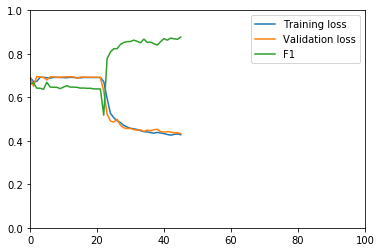

In [41]:
best_score = 0
mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'F1']
training_losses = []
validation_losses = []
f1_scores = []
x = []

train_step = math.ceil(len(train_x)*1.0/BATCH_SIZE)
val_step = math.ceil(len(validation_x)*1.0/BATCH_SIZE)
for epoch in mb:
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    x.append(epoch)
    
    ### TODO 6.1
    # Huấn luyện bằng hàm epoch_training()
    # Sử dụng tập train_dataset
    ### START CODE HERE
    training_loss = epoch_training(model, train_dataset, global_step, mb, train_step)
    ### END CODE HERE
    
    # Báo cáo kết quả train/huấn luyện
    mb.write('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    training_losses.append(training_loss)
    
    ### TODO 6.2
    # Đánh giá kết quả trên tập validation_dataset
    # bằng hàm epoch_evaluation()
    ### START CODE HERE
    
    valid_loss, valid_score = epoch_evaluation(model, validation_dataset, mb, val_step)
    ### END CODE HERE
    
    # Báo cáo kết quả validate
    mb.write('Finish validate epoch {} with loss {:.4f}, F1-score {:.4f}'.format(epoch,valid_loss, valid_score))
    validation_losses.append(valid_loss)
    f1_scores.append(valid_score)
    
    # Cập nhật đồ thị
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, f1_scores]], [0,EPOCHS], [0,1])
    
    # Update score và lưu model có score tốt nhất
    if best_score < valid_score:
        mb.write(">>> Improved F1-score from {:.4f} to {:.4f}".format(best_score, valid_score))
        # Update best_score
        best_score = valid_score
        # Save model
        model.save_weights(checkpoint_prefix.format(score=valid_score))
        
    

Sau khi hoàn thành quá trình huấn luyện, ta sẽ có được một model với các trọng số được lưu trong các checkpoint trong folder model.

Việc tiếp theo ta sẽ viết xây dựng một model nhờ việc có cấu trúc của class `SentimentAnalysisModel` và được load trọng số trong folder `/model` được triển khai trong file [app.py]('/app.py').